In [2]:
%matplotlib inline

import seaborn
import pandas
import geopandas
import pysal #python spatial analysis library
import numpy
import mapclassify #classification schemes for cloropeth maps
import matplotlib.pyplot as plt

# Mapas de cloropetas



## Principios

Los mapas de coropletas desempeñan un papel destacado en la ciencia de datos geográficos, ya que nos permiten mostrar atributos o variables no geográficas en un mapa geográfico. La palabra coropleta proviene de la raíz "choro", que significa "región".

Como tales, los mapas de coropletas representan datos a nivel de región y son apropiados para datos de unidades de área donde cada observación combina un valor de un atributo y una figura geométrica, generalmente un polígono.

La eficacia de un mapa de coropletas dependerá de la elección del esquema de clasificación junto con el color o la estrategia de simbolización adoptada.



## Clasificación de datos cuantitativos

La clasificación de datos considera el problema de dividir los valores de los atributos en grupos exhaustivos y mutuamente excluyentes. La forma precisa en que se haga esto dependerá de la escala de medición del atributo en cuestión. Para los atributos cuantitativos (ordinal, intervalo, escalas de razón), las clases tendrán un orden explícito.

Los diferentes esquemas de clasificación se obtienen de su definición de los límites de clase. La elección del esquema de clasificación debe tener en cuenta la distribución estadística de los valores de los atributos.

In [9]:
mx = geopandas.read_file("./data/mexico/mexicojoin.shp")
print(len(mx))
mx[['NAME', 'PCGDP1940']].head()

32


,NAME,PCGDP1940
0,Baja California Norte,22361.0
1,Baja California Sur,9573.0
2,Nayarit,4836.0
3,Jalisco,5309.0
4,Aguascalientes,10384.0


C:\Users\Julen Montes\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Julen Montes\Anaconda\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


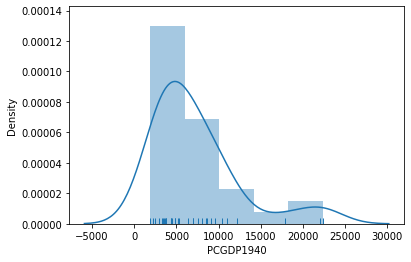

In [29]:
h = seaborn.distplot(mx['PCGDP1940'], bins=5, rug=True, kde=True);

In [24]:
mx['PCGDP1940'].describe()

count       32.000000
mean      7230.531250
std       5204.952883
min       1892.000000
25%       3701.750000
50%       5256.000000
75%       8701.750000
max      22361.000000
Name: PCGDP1940, dtype: float64

Para los atributos cuantitativos, primero ordenamos los datos por su valor, de modo que x0≤x2…≤xn−1. 

Para un número predeterminado de clases k, el problema de clasificación se reduce a la selección de k−1 puntos de ruptura a lo largo de los valores ordenados que separan los valores en grupos mutuamente excluyentes y exhaustivos.

De hecho, la determinación del histograma anterior puede verse como un enfoque para esta selección.

En la figura, tenemos cinco clases que se pueden extraer con una llamada explícita a la función hist:

In [33]:
counts, bins, patches = h.hist(mx['PCGDP1940'], bins=5)

- El objeto **counts** captura cuántas observaciones tiene cada categoría en la clasificación:

In [35]:
counts

array([17.,  9.,  3.,  1.,  2.])

- El objeto **bins** almacena estos puntos de ruptura que nos interesan cuando consideramos esquemas de clasificación (el objeto **patches** se puede ignorar en este contexto, ya que almacena las geometrías del diagrama del histograma):

In [43]:
bins

array([ 1892. ,  5985.8, 10079.6, 14173.4, 18267.2, 22361. ])

Esto produce 5 contenedores, el primero con un límite inferior de 1892 y un límite superior de 5985,8 que contiene 17 observaciones. La determinación del ancho del intervalo (w) y el número de contenedores seabornse basa en la regla Freedman-Diaconis:

    w = 2 ∗ IQR ∗ n^(−1/3)
    
Dado 'w' el número de contenedores (k) es:

    k = (max−min)/w.

A continuación presentamos varios enfoques para crear estos puntos de ruptura que siguen criterios que pueden ser de interés en diferentes contextos, ya que se enfocan en diferentes prioridades.

### Intervalos iguales

Este es un caso especial de un clasificador más general conocido como "intervalos iguales", donde cada uno de los contenedores tiene el mismo ancho en el espacio de valores. 

Por un valor dado de 'k', la clasificación de intervalos iguales divide el rango del espacio de atributos en 'k' Intervalos de igual longitud, teniendo cada intervalo un ancho: 
    
    w = x0 − xn − 1k. 
    
Así, la clase máxima es (xn−1−w,xn−1] y la primera clase es (−∞,xn−1−(k−1)w].

Los intervalos iguales tienen la doble ventaja de simplicidad y facilidad de interpretación. Sin embargo, **esta regla solo considera los valores extremos de la distribución y, en algunos casos, esto puede resultar en que una o más clases sean escasas**. Este es claramente el caso en nuestro conjunto de datos de ingresos, ya que la mayoría de los valores se colocan en las dos primeras clases, dejando las últimas tres clases bastante escasas:

In [44]:
ei5 = mapclassify.EqualInterval(mx['PCGDP1940'], k=5)
ei5

EqualInterval               

      Interval         Count
----------------------------
[ 1892.00,  5985.80] |    17
( 5985.80, 10079.60] |     9
(10079.60, 14173.40] |     3
(14173.40, 18267.20] |     1
(18267.20, 22361.00] |     2

In [45]:
ei5.bins

array([ 5985.8, 10079.6, 14173.4, 18267.2, 22361. ])

### Cuantiles

Para evitar el problema potencial de las clases dispersas, los cuantiles de la distribución se pueden utilizar para identificar los límites de las clases. De hecho, cada clase tendrá aproximadamente∣nk∣observaciones utilizando el clasificador de cuantiles. 

Si k=5 Los quintiles de la muestra se utilizan para definir los límites superiores de cada clase, lo que da como resultado la siguiente clasificación:

In [52]:
q5 = mapclassify.Quantiles(mx.PCGDP1940, k=5)
q5

Quantiles                   

      Interval         Count
----------------------------
[ 1892.00,  3576.20] |     7
( 3576.20,  4582.80] |     6
( 4582.80,  6925.20] |     6
( 6925.20,  9473.00] |     6
( 9473.00, 22361.00] |     7

Tenga en cuenta que si bien el número de valores en cada clase es aproximadamente igual, los anchos de los primeros cuatro intervalos son bastante diferentes:

In [58]:
q5.bins[1:]-q5.bins[:-1]

array([ 1006.6,  2342.4,  2547.8, 12888. ])

Los diferentes anchos de los intervalos pueden ser marcadamente diferentes, lo que puede dar lugar a problemas de interpretación. Un segundo desafío al que se enfrentan los cuantiles surge cuando hay una gran cantidad de valores duplicados en la distribución, de modo que los límites para una o más clases se vuelven ambiguos. Por ejemplo, si uno tuviera una variable conn=20 pero 10 de las observaciones tomaron el mismo valor que fue el mínimo observado, luego para valores de k>2, los límites de clase se vuelven mal definidos debido a una simple regla de división en el n/k El valor observado clasificado dependería de cómo se tratan los empates al clasificar.

In [60]:
numpy.random.seed(12345)
x = numpy.random.randint(0,10,20)
x[0:10] = x.min()
x

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 7, 6, 0, 2, 9, 1, 2, 6, 7])

In [61]:
ties = mapclassify.Quantiles(x, k=5)
ties

C:\Users\Julen Montes\AppData\Roaming\Python\Python38\site-packages\mapclassify\classifiers.py:234: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
C:\Users\Julen Montes\AppData\Roaming\Python\Python38\site-packages\mapclassify\classifiers.py:237: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


Quantiles           

  Interval     Count
--------------------
[0.00, 0.00] |    11
(0.00, 1.40] |     1
(1.40, 6.20] |     4
(6.20, 9.00] |     4

### Desviación estándar media

Nuestro tercer clasificador usa la **media muestral y desviación estándar de la muestra para definir los límites de clase como cierta distancia de la media de la muestra, siendo la distancia un múltiplo de la desviación estándar.** 

Por ejemplo, una definición común de k=5 es establecer el límite superior de la primera clase en dos desviaciones estándar (cu0=x¯−2s), y las clases intermedias deben tener límites superiores dentro de una desviación estándar (cu1=x¯−s, cu2=x¯+s, cu3=x¯+2s). Cualquier valor mayor (menor) que dos desviaciones estándar por encima (por debajo) de la media se coloca en la clase superior (inferior).

In [64]:
mx['PCGDP1940'].std()

5204.952883083666

In [65]:
mx['PCGDP1940'].mean()

7230.53125

In [66]:
mx['PCGDP1940'].mean() + mx['PCGDP1940'].std()

12435.484133083666

In [67]:
mx['PCGDP1940'].mean() - mx['PCGDP1940'].std()

2025.5783669163338

In [62]:
msd = mapclassify.StdMean(mx['PCGDP1940'])
msd

StdMean                     

      Interval         Count
----------------------------
(    -inf, -3179.37] |     0
(-3179.37,  2025.58] |     1
( 2025.58, 12435.48] |    28
(12435.48, 17640.44] |     0
(17640.44, 22361.00] |     3

Este clasificador se utiliza mejor cuando los datos se distribuyen normalmente o, al menos, cuando la media de la muestra es una medida significativa para anclar la clasificación. Claramente, este no es el caso de nuestros datos de ingresos, ya que el sesgo positivo da como resultado una pérdida de información cuando usamos la desviación estándar. La falta de simetría conduce a un límite superior inadmisible para la primera clase, así como a una concentración de la gran mayoría de valores en la clase media

### Descansos máximos

El clasificador de rupturas máximas decide dónde establecer los puntos de ruptura entre clases considerando la diferencia entre los valores ordenados. Es decir, en lugar de considerar un valor del conjunto de datos en sí mismo, mira qué tan separado está cada valor del siguiente en la secuencia ordenada. El clasificador luego coloca el k−1 puntos de ruptura entre los pares de valores más separados entre sí en toda la secuencia, procediendo en orden descendente en relación con el tamaño de las rupturas:

In [70]:
mb5 = mapclassify.MaximumBreaks(mx['PCGDP1940'], k=5)
mb5

MaximumBreaks               

      Interval         Count
----------------------------
[ 1892.00,  5854.00] |    17
( 5854.00, 11574.00] |    11
(11574.00, 14974.00] |     1
(14974.00, 19890.50] |     1
(19890.50, 22361.00] |     2

Los descansos máximos es un enfoque apropiado cuando estamos interesados ​​en asegurarnos de que las observaciones de cada clase estén separadas de las de las clases vecinas. Como tal, funciona bien en los casos en que la distribución de valores no es unimodal. Además, el algoritmo es relativamente rápido de calcular. Sin embargo, su simplicidad a veces puede causar resultados inesperados. En la medida en que solo considera la parte superior k−1 diferencias entre valores consecutivos, otras diferencias y disimilitudes dentro del grupo más matizadas pueden ignorarse

### Boxplot

La clasificación del diagrama de caja es una combinación de los clasificadores de desviación estándar y cuantiles. 

Aquí 'k' está predefinido en seis, con el límite superior de la clase 0 establecido en q0.25−hIQR. 

IQR = q0.75−q0.25 es el rango intercuartil; h corresponde a la bisagra, o al multiplicador de la IQRpara obtener los límites de los bigotes. 

El límite inferior de la sexta clase se establece en q0.75 + hIQR. 

Las clases intermedias tienen sus límites superiores establecidos en los percentiles 0,25, 0,50 y 0,75 de los valores de los atributos.

In [71]:
bp = mapclassify.BoxPlot(mx['PCGDP1940'])
bp

BoxPlot                     

      Interval         Count
----------------------------
(    -inf, -3798.25] |     0
(-3798.25,  3701.75] |     8
( 3701.75,  5256.00] |     8
( 5256.00,  8701.75] |     8
( 8701.75, 16201.75] |     5
(16201.75, 22361.00] |     3

Los valores que caen en cualquiera de las clases extremas se definen como valores extremos

El valor predeterminado para la bisagra es h=1.5 en PySAL. Sin embargo, esto puede ser especificado por el usuario para una clasificación alternativa:

In [72]:
bp1 = mapclassify.BoxPlot(mx['PCGDP1940'], hinge=1)
bp1

BoxPlot                     

      Interval         Count
----------------------------
(    -inf, -1298.25] |     0
(-1298.25,  3701.75] |     8
( 3701.75,  5256.00] |     8
( 5256.00,  8701.75] |     8
( 8701.75, 13701.75] |     5
(13701.75, 22361.00] |     3

Si lo hace, afectará la definición de las clases atípicas, así como las clases internas vecinas.

### Roturas cabeza-cola (Head Tail Breaks)

Se basa en una partición recursiva de los datos utilizando divisiones en torno a medios iterativos. 

El proceso de división continúa hasta que las distribuciones dentro de cada una de las clases ya no muestran una distribución de cola gruesa en el sentido de que existe un equilibrio entre el número de valores más pequeños y más grandes asignados a cada clase.

In [73]:
ht = mapclassify.HeadTailBreaks(mx['PCGDP1940'])
ht

HeadTailBreaks              

      Interval         Count
----------------------------
[ 1892.00,  7230.53] |    20
( 7230.53, 12244.42] |     9
(12244.42, 20714.00] |     1
(20714.00, 22163.00] |     1
(22163.00, 22361.00] |     1

Para los datos con una distribución de colas pesadas, como la ley de potencia y las distribuciones logarítmicas normales, el clasificador de roturas de cabeza y cola puede ser particularmente eficaz.

### Jenks Caspall

Este enfoque, así como los dos siguientes, aborda el desafío de la clasificación desde una perspectiva **heurística**, más que determinista. 

Este algoritmo tiene como objetivo **minimizar la suma de las desviaciones absolutas alrededor de las MEDIAS de clase.**

El enfoque comienza con un número predeterminado de clases y un conjunto inicial arbitrario de rupturas de clases, por ejemplo, utilizando quintiles. El algoritmo intenta mejorar la función objetivo considerando el movimiento de observaciones entre clases adyacentes.

Se realizará el movimiento candidato que resulte en la mayor reducción de la función objetivo, y el proceso continuará hasta que no sean posibles otros movimientos de mejora.

In [76]:
numpy.random.seed(12345)
jc5 = mapclassify.JenksCaspall(mx['PCGDP1940'], k=5)
jc5

JenksCaspall                

      Interval         Count
----------------------------
[ 1892.00,  2934.00] |     4
( 2934.00,  4414.00] |     9
( 4414.00,  6399.00] |     5
( 6399.00, 12132.00] |    11
(12132.00, 22361.00] |     3

### Fisher Jenks <==========

El segundo algoritmo óptimo adopta un enfoque de programación dinámica para **minimizar la suma de las desviaciones absolutas alrededor de las MEDIANAS de clase.**

A diferencia del enfoque de Jenks-Caspall, se garantiza que Fisher-Jenks **producirá una clasificación óptima para un número predeterminado de clases**:

In [77]:
numpy.random.seed(12345)
fj5 = mapclassify.FisherJenks(mx['PCGDP1940'], k=5)
fj5

FisherJenks                 

      Interval         Count
----------------------------
[ 1892.00,  5309.00] |    17
( 5309.00,  9073.00] |     8
( 9073.00, 12132.00] |     4
(12132.00, 17816.00] |     1
(17816.00, 22361.00] |     2

### Max-p

Finalmente, los clasificadores max-p adoptan el algoritmo subyacente al método de construcción de la región max-p

Es similar en espíritu a Jenks Caspall en el sentido de que considera el intercambio codicioso entre clases adyacentes para mejorar la función objetivo. Sin embargo, es una heurística, por lo que, a diferencia de Fisher-Jenks, no hay una solución óptima garantizada:

In [79]:
mp5 = mapclassify.MaxP(mx['PCGDP1940'], k=5)
mp5

MaxP                        

      Interval         Count
----------------------------
[ 1892.00,  3569.00] |     7
( 3569.00,  5309.00] |    10
( 5309.00,  7990.00] |     5
( 7990.00, 10384.00] |     5
(10384.00, 22361.00] |     5

### Comparación de esquemas de clasificación

Para la clasificación de mapas, un criterio de optimización que se puede utilizar es una **medida de ajuste**. 

En PySAL, la **"desviación absoluta alrededor de las medianas de clase"** (ADCM) se calcula y proporciona una medida de ajuste que permite la comparación de clasificadores alternativos para el mismo valor de 'k'.

Para ver esto, podemos comparar diferentes clasificadores para k=5 sobre los datos de México:

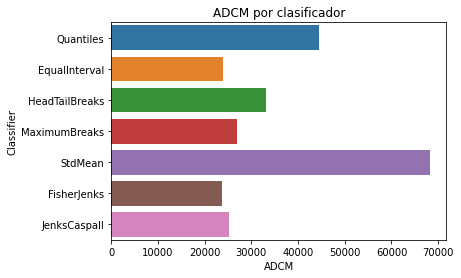

In [88]:
class5 = q5, ei5, ht, mb5, msd, fj5, jc5
fits = numpy.array([ c.adcm for c in class5]) #<---- c.adcm
data = pandas.DataFrame(fits)
data['classifier'] = [c.name for c in class5]
data.columns = ['ADCM', 'Classifier']
ax = seaborn.barplot(y='Classifier', x='ADCM', data=data)
ax.set_title('ADCM por clasificador')
plt.show()

Como era de esperar, el clasificador de **Fisher-Jenks domina a todos los demás clasificadores** k = 5 con un ACDM de 23.729. 

Curiosamente, el clasificador de intervalos iguales funciona bien a pesar de los problemas asociados con ser sensible a los valores extremos en la distribución. El clasificador de desviación estándar media tiene un ajuste muy deficiente debido a la naturaleza sesgada de los datos y la asignación concentrada de la mayoría de las observaciones a la clase central.

In [91]:
mx['q540'] = q5.yb
mx['ei540'] = ei5.yb
mx['ht40'] = ht.yb
mx['mb540'] = mb5.yb
mx['msd40'] = msd.yb
mx['fj540'] = fj5.yb
mx['jc540'] = jc5.yb

In [94]:
mxs = mx.sort_values('PCGDP1940')

In [95]:
def highlight_values(val):
    if val==0:
        return 'background-color: %s' % '#ffffff'
    elif val==1:
        return 'background-color: %s' % '#e0ffff'
    elif val==2:
        return 'background-color: %s' % '#b3ffff'
    elif val==3:
        return 'background-color: %s' % '#87ffff'
    elif val==4:
        return 'background-color: %s' % '#62e4ff'
    else:
        return ''

In [96]:
t = mxs[['NAME', 'PCGDP1940', 'q540', 'ei540', 'ht40', 'mb540', 'msd40', 'fj540', 'jc540']]
t.style.applymap(highlight_values)

,NAME,PCGDP1940,q540,ei540,ht40,mb540,msd40,fj540,jc540
19,Oaxaca,1892.000000,0,0,0,0,1,0,0
18,Guerrero,2181.000000,0,0,0,0,2,0,0
20,Tabasco,2459.000000,0,0,0,0,2,0,0
21,Chiapas,2934.000000,0,0,0,0,2,0,0
8,Michoacan de Ocampo,3327.000000,0,0,0,0,2,0,1
9,Mexico,3408.000000,0,0,0,0,2,0,1
15,Puebla,3569.000000,0,0,0,0,2,0,1
17,Tlaxcala,3605.000000,1,0,0,0,2,0,1
27,Zacatecas,3734.000000,1,0,0,0,2,0,1
14,Campeche,3758.000000,1,0,0,0,2,0,1


La inspección de esta tabla revela una serie de resultados interesantes. Primero, el único estado mexicano que es tratado de manera consistente en los clasificadores k = 5 es Baja California Norte, que está ubicado en la clase más alta por todos los clasificadores. En segundo lugar, el clasificador de desviación estándar media tiene una primera clase vacía debido al límite superior inadmisible y la concentración excesiva de valores en la clase central (2).

Finalmente, podemos considerar una vista de nivel meso de los resultados de la clasificación comparando el número de valores asignados a cada clase en los diferentes clasificadores:

In [97]:
pandas.DataFrame({c.name: c.counts for c in class5},
                 index=['Class-{}'.format(i) for i in range(5)])

,Quantiles,EqualInterval,HeadTailBreaks,MaximumBreaks,StdMean,FisherJenks,JenksCaspall
Class-0,7,17,20,17,0,17,4
Class-1,6,9,9,11,1,8,9
Class-2,6,3,1,1,28,4,5
Class-3,6,1,1,1,0,1,11
Class-4,7,2,1,2,3,2,3


Al hacerlo, se resaltan las similitudes entre Fisher Jenks y los intervalos iguales, ya que los recuentos de distribución son muy similares, ya que los dos enfoques coinciden en los 17 estados asignados a la primera clase. 

De hecho, la única observación que distingue a los dos clasificadores es el tratamiento de Baja California Sur, que se mantiene en la clase 1 en intervalos iguales, pero Fisher Jenks lo asigna a la clase 2.



##  Color

Habiendo considerado la evaluación de la distribución estadística de los valores de los atributos y los enfoques de clasificación alternativos, el siguiente paso es seleccionar la simbolización y el esquema de color. Junto con la elección del clasificador, estos determinarán la efectividad general del mapa de coropletas para representar la distribución espacial de los valores de los atributos.

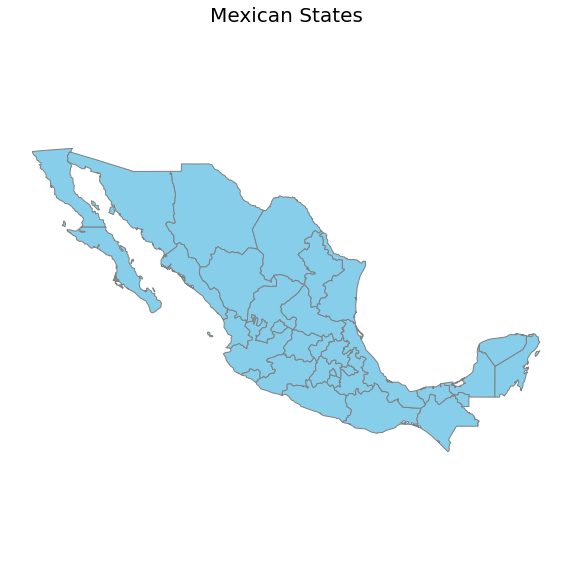

In [114]:
mx = geopandas.read_file('./data/mexico/mexicojoin.shp')
f, ax = plt.subplots(1, figsize=(10, 10))
mx.plot(ax=ax, color='skyblue', edgecolor='grey')
ax.set_axis_off()
ax.set_title('Mexican States',fontdict={'fontsize':20})
plt.axis('equal')
plt.show()

Antes de examinar los valores de los atributos, es importante tener en cuenta que **las unidades espaciales para estos estados están lejos de ser homogéneas en sus formas y tamaños**. **Esto puede tener un gran impacto en las capacidades de reconocimiento de patrones de nuestro cerebro**, ya que tendemos a sentirnos atraídos por los polígonos más grandes. Sin embargo, cuando consideramos la distribución estadística anterior, a cada observación se le dio el mismo peso. Así, la distribución espacial se vuelve más complicada de evaluar desde una perspectiva visual y estadística.

Con esta calificación en mente, exploraremos la construcción de mapas de coropletas usando geopandas:

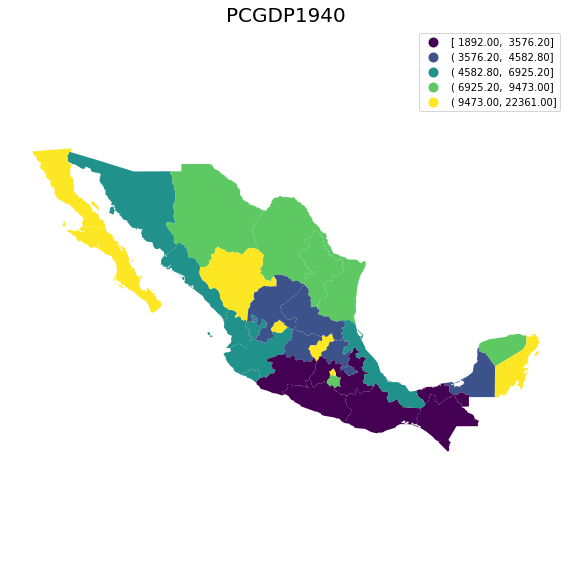

In [117]:
mx = geopandas.read_file('./data/mexico/mexicojoin.shp')
f, ax = plt.subplots(1, figsize=(10, 10))
mx.plot(ax=ax, column='PCGDP1940', legend=True, scheme='Quantiles')
ax.set_axis_off()
ax.set_title('PCGDP1940',fontdict={'fontsize':20})
plt.axis('equal')
plt.show()

Tenga en cuenta que el valor predeterminado para la leyenda es dos informes con dos decimales. Si lo deseamos, esto se puede cambiar anulando el parámetro 'fmt':

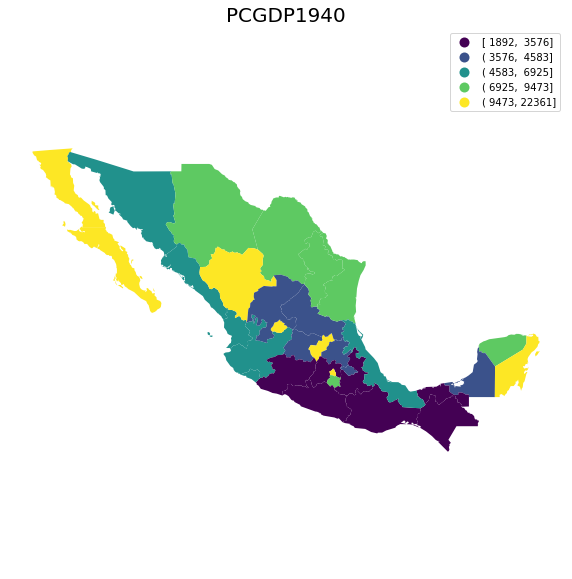

In [121]:
f, ax = plt.subplots(1, figsize=(10, 10))
mx.plot(ax=ax, column='PCGDP1940', legend=True, scheme='Quantiles', legend_kwds={'fmt':'{:.0f}'})
ax.set_axis_off()
ax.set_title('PCGDP1940',fontdict={'fontsize':20})
plt.axis('equal')
plt.show()

El mapa de color predeterminado utilizado por geopandas es viridis, que es un esquema secuencial de varios tonos, con los tonos más oscuros (más claros) que representan valores más bajos (más altos) para el atributo en cuestión. 

La elección de un esquema de color para un mapa de coropletas debe basarse en el tipo de variable en consideración

- secuencial

- divergente

- cualitativo




### Esquemas de colores secuenciales

Nuestro atributo se mide en dólares y se caracteriza por ser un atributo secuencial . Para elegir un esquema secuencial apropiado, podemos anular el  parámetro 'cmap':

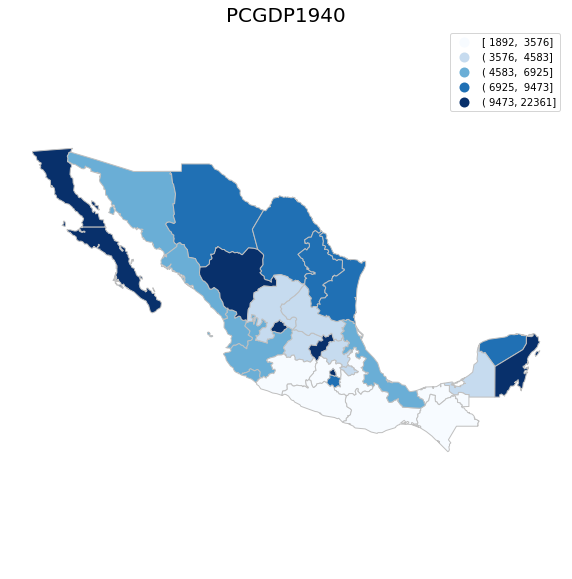

In [129]:
f, ax = plt.subplots(1, figsize=(10, 10))
mx.plot(ax=ax, column='PCGDP1940', legend=True, scheme='Quantiles', legend_kwds={'fmt':'{:.0f}'}, 
        cmap='Blues', edgecolor='silver')
ax.set_axis_off()
ax.set_title('PCGDP1940',fontdict={'fontsize':20})
plt.axis('equal')
plt.show()

### Esquemas de colores divergentes

Un tipo de atributo ligeramente diferente es el denominado atributo de valores "divergentes". Esto es útil cuando se desea poner el **mismo énfasis en los valores críticos de rango medio, así como en los extremos en ambos extremos de la distribución**. Los colores claros se utilizan para enfatizar la clase de rango medio, mientras que los colores oscuros con matices contrastantes se utilizan para distinguir los extremos bajos y altos.

Para ilustrar esto para los datos de ingresos mexicanos, podemos derivar una nueva variable que mide el cambio en el rango de un estado en la distribución del ingreso entre 1940 y 2000:

In [131]:
rnk = mx.rank(ascending=False) # ascending ranks 1=high, n=lowest
rnk['NAME']=mx['NAME']
delta_rnk = rnk.PCGDP1940 - rnk.PCGDP2000
delta_rnk
cls = numpy.digitize(delta_rnk, [-5, 0, 5, 20])
cls

array([1, 1, 0, 2, 1, 2, 1, 1, 2, 3, 2, 2, 1, 1, 4, 3, 1, 1, 2, 2, 3, 1,
       2, 2, 2, 1, 0, 0, 2, 3, 2, 0], dtype=int64)

Aquí hemos creado cuatro clases para los cambios de rango: [-inf, -5), [-5, 0), [0, 5), [5, 20]. 

Tenga en cuenta que estos son rangos descendentes, por lo que el estado más rico en cualquier período tiene un rango de 1 y, por lo tanto, al considerar el cambio en los rangos, un cambio negativo refleja un descenso en la distribución del ingreso.

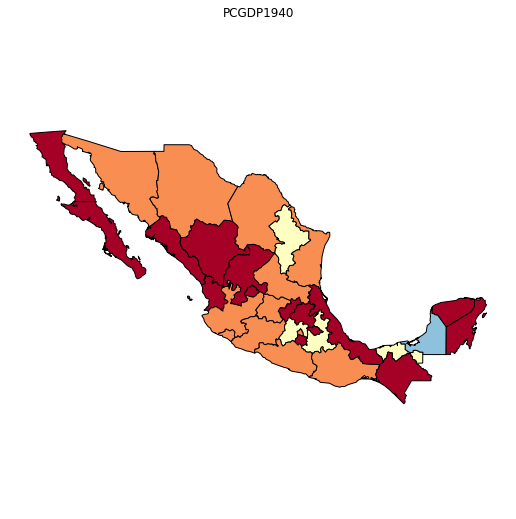

In [142]:
f, ax = plt.subplots(1, figsize=(9, 9))
mx.assign(cl=cls).plot(ax=ax, column='cl', categorical=True, cmap='RdYlBu',
           scheme='equal_interval', k=4, edgecolor='black')
ax.set_axis_off()
ax.set_title('PCGDP1940')
plt.axis('equal')
plt.show()

### Esquemas de color cualitativos

El conjunto de datos de México también tiene varias variables que se encuentran en una escala de medición nominal. 

Uno de ellos es una variable de definición de región que agrupa estados individuales en grupos contiguos de características similares:

In [143]:
mx['HANSON98'].head()

0    1.0
1    2.0
2    2.0
3    3.0
4    2.0
Name: HANSON98, dtype: float64

Este esquema de regionalización divide a México en 5 regiones. Una forma ingenua (e incorrecta) de mostrar esto sería tratar la variable de región como secuencial y usar un UserDefinedclasificador para mostrar las regiones:

In [144]:
import numpy as np
h5 = mapclassify.UserDefined(mx['HANSON98'], bins=np.arange(1,6).tolist())
h5.fmt = '{:.0f}'
h5

UserDefined     

Interval   Count
----------------
[1, 1] |     6
(1, 2] |     7
(2, 3] |    10
(3, 4] |     2
(4, 5] |     7

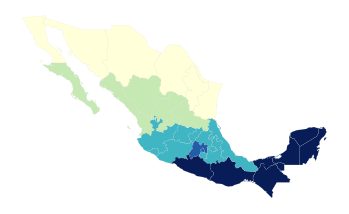

In [147]:
_ = h5.plot(mx, axis_on=False)

Esto no es correcto porque la variable de región no está en una escala de intervalo, por lo que las diferencias entre los valores no tienen importancia cuantitativa, sino que los valores simplemente indican la pertenencia a la región. Sin embargo, la coropleta anterior da una clara pista visual de que las regiones del sur tienen valores más grandes que las del norte, ya que el mapa de color implica un gradiente de intensidad.

Una visualización más apropiada es utilizar una paleta de colores "cualitativa": Por ejemplo, mediante Paste1

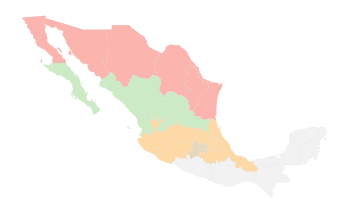

In [159]:
_ = h5.plot(mx, cmap='Pastel1', axis_on=False)